# Upward continuation of gravity disturbance produced by a prism

This code illustrates how to compute the upward continuation of gravity disturbance produced by a homogeneous rectangular prism via Fourier transform and equivalent-layer technique. We presume that the gravity disturbance can be approximated by the vertical component of the gravitational attraction produced by the prism.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gravmag import eqlayer, filters, transforms, convolve
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf

### Model

In [2]:
# Create a model formed by a single prism
model = np.array([[-500, 500, 0, 2000, 10, 1010]])

density = np.array([2000]) # 2000 kg/m³ = 2 g/cm³

### Points were we compute the synthetic data

In [3]:
# number of points along x and y
shape = (60, 60)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)

yp = np.ravel(yp)
xp = np.ravel(xp)

# constant vertical coordinate of the simulated gravity data
z_data = -150

zp = np.zeros_like(yp) + z_data

coordinates = np.vstack([xp, yp, zp])

In [4]:
# Grid spacing
dx = (area[1] - area[0])/(shape[0]-1)
dy = (area[3] - area[2])/(shape[1]-1)

In [5]:
print(dx, dy)

169.4915254237288 169.4915254237288


In [6]:
# constant vertical coordinate of the upward continuation plane
z_upward = z_data - 300

continuation_points = coordinates.copy()
continuation_points[2] = z_upward

### Synthetic gravity disturbance (in mGal)

In [7]:
# Compute the vertical component of acceleration
gz_true = rp.grav(coordinates=coordinates, prisms=model, density=density, field='g_z')

gz_true += np.random.normal(scale=1., size=gz_true.size)

In [8]:
gz_upward_true = rp.grav(coordinates=continuation_points, prisms=model, density=density, field='g_z')

### Estimated equivalent layer

In [9]:
# layer z
z_layer = -150 + 2.5*(0.5*(dx+dy))

In [10]:
# kernel matrix associated with the equivalent layer
G = eqlayer.kernel_matrix_monopoles(coordinates, z_layer, field="z")

In [11]:
# estimated equivalent layer
p_estimated = np.linalg.solve(G.T@G, G.T@gz_true)

In [12]:
# gravity disturbance predicted by the estimated equivalent layer
gz_predicted = G@p_estimated

### Upward continuation via equivalent-layer technique

In [13]:
# kernel matrix associated with upward continuation
G = eqlayer.kernel_matrix_monopoles(continuation_points, z_layer, field="z")

In [14]:
# upward continued field obtained via equivalent-layer technique
gz_upward_predicted_eql = G@p_estimated

### Upward continuation via Fourier transform

In [15]:
# compute 2D Fourier transform of gz_true with padding
FT_gz_true = transforms.DFT(data=gz_true.reshape(shape), pad_mode='linear_ramp')

# compute wavenumbers
kx, ky, kz = transforms.wavenumbers(FT_gz_true.shape, dx, dy)

In [16]:
# define the continuation filter
up_continuation_filter = [filters.continuation(kz=kz, dz=z_upward-z_data)]

In [17]:
# compute the upward continued field in Fourier domain
FT_gz_upward_predicted_fourier = convolve.compute(FT_gz_true, up_continuation_filter)

In [18]:
# transform the upward continued field to space domain
gz_upward_predicted_fourier = transforms.IDFT(FT_gz_upward_predicted_fourier, unpad=True, grid=False)

### Plot the results

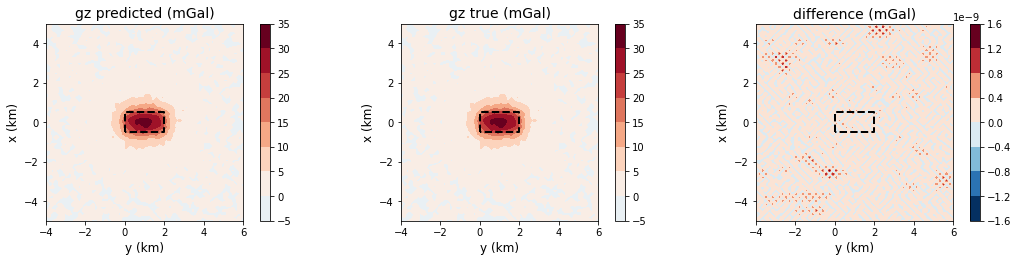

In [19]:
true_fields = [gz_true]
computed_fields = [gz_predicted]

bounds, diffs = plf.bounds_diffs(computed_fields, true_fields)

fields = plf.fields_list(computed_fields, true_fields, diffs)

titles = [
    'gz predicted (mGal)', 
    'gz true (mGal)', 
    'difference (mGal)'
]

windows = [1, 2, 3]

plt.figure(figsize=(15,10))

for w, window in enumerate(windows):

    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

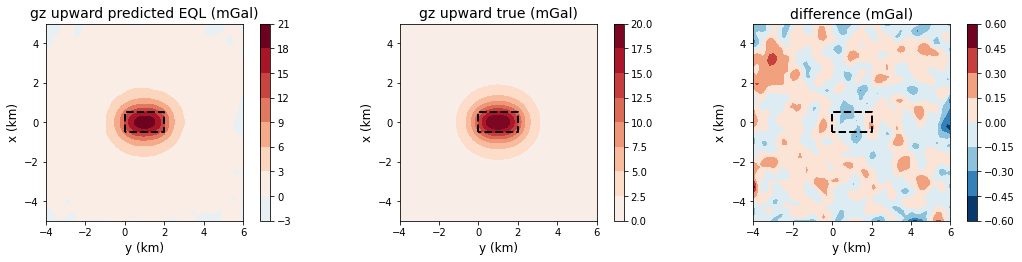

In [20]:
true_fields = [gz_upward_true]
computed_fields = [gz_upward_predicted_eql]

bounds, diffs = plf.bounds_diffs(computed_fields, true_fields)

fields = plf.fields_list(computed_fields, true_fields, diffs)

titles = [
    'gz upward predicted EQL (mGal)', 
    'gz upward true (mGal)', 
    'difference (mGal)'
]

windows = [1, 2, 3]

plt.figure(figsize=(15,10))

for w, window in enumerate(windows):

    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

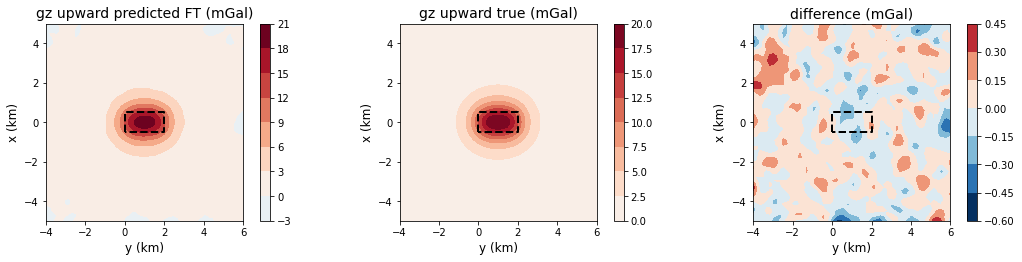

In [21]:
true_fields = [gz_upward_true]
computed_fields = [gz_upward_predicted_fourier]

bounds, diffs = plf.bounds_diffs(computed_fields, true_fields)

fields = plf.fields_list(computed_fields, true_fields, diffs)

titles = [
    'gz upward predicted FT (mGal)', 
    'gz upward true (mGal)', 
    'difference (mGal)'
]

windows = [1, 2, 3]

plt.figure(figsize=(15,10))

for w, window in enumerate(windows):

    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()